#**On the wine dataset**

In [41]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, roc_auc_score, silhouette_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [42]:
data=load_wine()
df = pd.DataFrame(data['data'], columns=data['feature_names'])
df['target'] = data['target']
stat_summary = df.describe()
print(stat_summary)

          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   
min         0.9

In [43]:
print("Feature Names:", data['feature_names'])
print("Target Names:", data['target_names'])

Feature Names: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Target Names: ['class_0' 'class_1' 'class_2']


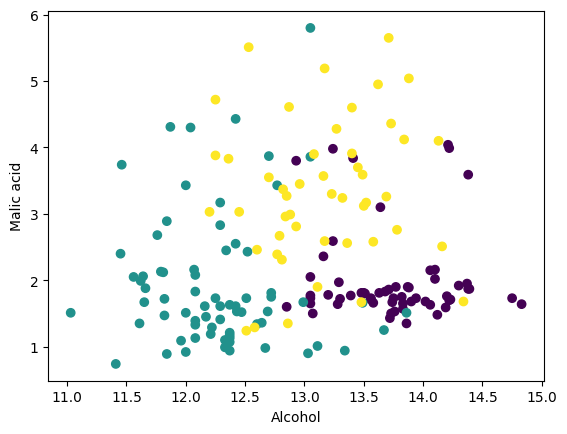

In [44]:
plt.scatter(df['alcohol'], df['malic_acid'], c=df['target'], cmap='viridis')
plt.xlabel('Alcohol')
plt.ylabel('Malic acid')
plt.show()

In [45]:
p1 = 2
p2 = 3

# PCA with p1 components
pca1 = PCA(n_components=p1)
X_pca1 = pca1.fit_transform(df.iloc[:, :-1])

# PCA with p2 components
pca2 = PCA(n_components=p2)
X_pca2 = pca2.fit_transform(df.iloc[:, :-1])

explained_variance_ratio_1 = pca1.explained_variance_ratio_
explained_variance_ratio_2 = pca2.explained_variance_ratio_
print(f"Variance explained by the first {p1} components: {explained_variance_ratio_1}")
print(f"Variance explained by the first {p2} components: {explained_variance_ratio_2}")

Variance explained by the first 2 components: [0.99809123 0.00173592]
Variance explained by the first 3 components: [9.98091230e-01 1.73591562e-03 9.49589576e-05]


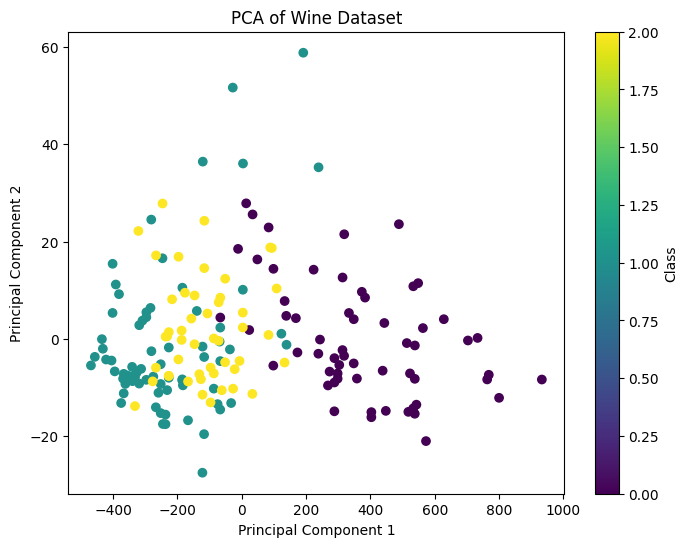

In [46]:
pca_df = pd.DataFrame(data=X_pca1, columns=[f'PC{i}' for i in range(1, p1 + 1)])
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=data.target, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Wine Dataset')
plt.colorbar(label='Class')
plt.show()

Logistic Regression Accuracy: 0.69


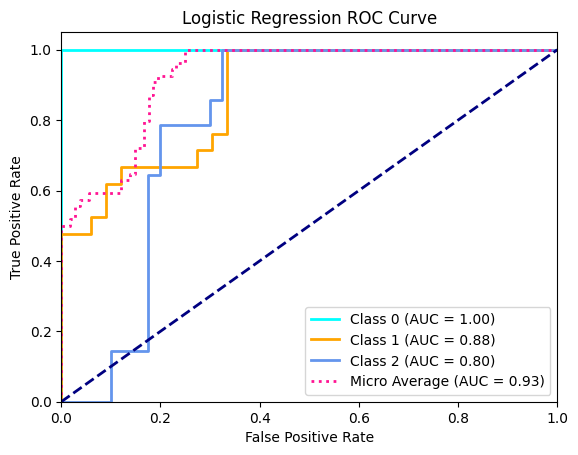

Logistic Regression Confusion Matrix:
[[19  0  0]
 [ 0 14  7]
 [ 1  9  4]]

Random Forest Accuracy: 0.74


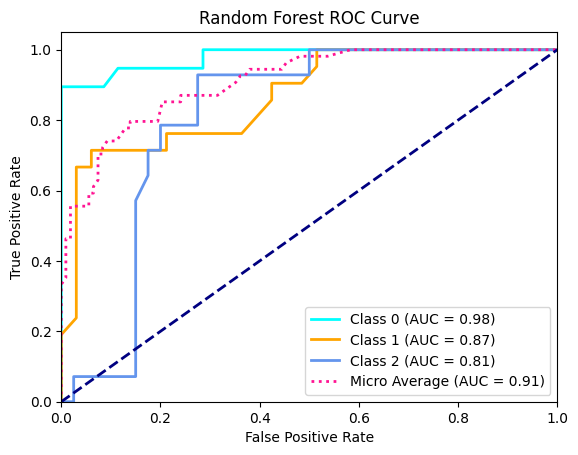

Random Forest Confusion Matrix:
[[17  0  2]
 [ 1 15  5]
 [ 0  6  8]]



In [47]:
y=df['target']
X_train, X_test, y_train, y_test = train_test_split(X_pca1, y, test_size=0.3, random_state=42)

# Classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier()
}

# Train and evaluate classifiers
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {accuracy:.2f}')

    # ROC curve
    y_test_binarized = label_binarize(y_test, classes=np.unique(y))
    y_pred_prob = clf.predict_proba(X_test)

    n_classes = len(np.unique(y))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr['micro'], tpr['micro'], _ = roc_curve(y_test_binarized.ravel(), y_pred_prob.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

    # Plot ROC curve
    plt.figure()
    lw = 2
    colors = cycle(['aqua', 'orange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot(fpr['micro'], tpr['micro'], color='deeppink', linestyle=':', lw=lw, label=f'Micro Average (AUC = {roc_auc["micro"]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} Confusion Matrix:\n{cm}\n')

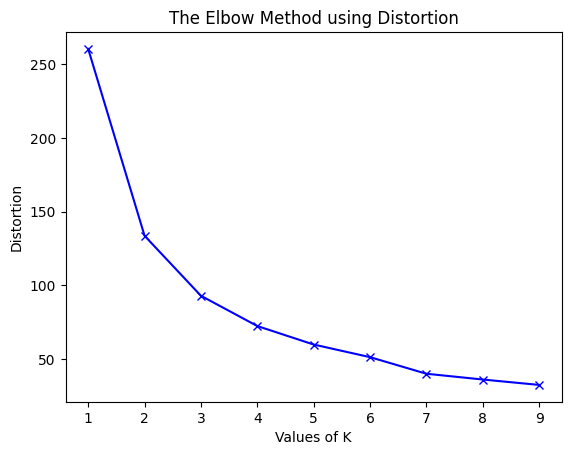

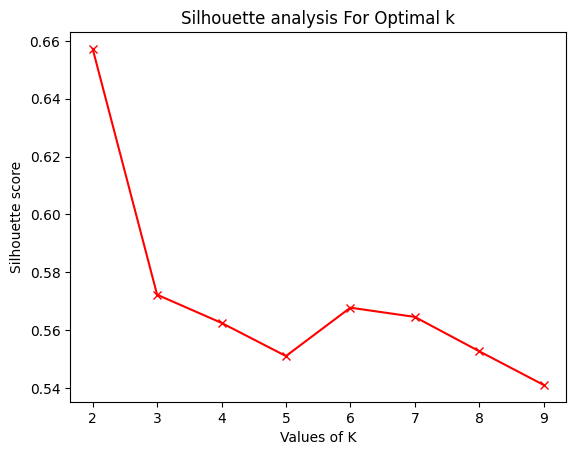

In [48]:
distortions = []
inertias = []
K = range(1, 10)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k,n_init=10).fit(X_pca1)
    kmeanModel.fit(X_pca1)

    distortions.append(sum(np.min(cdist(X_pca1, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_pca1.shape[0])
    inertias.append(kmeanModel.inertia_)


plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

#Silhouette Score

range_n_clusters = range(2, 10)
silhouette_avg = []

for num_clusters in range_n_clusters:
    # Initialize k-means
    kmeans = KMeans(n_clusters=num_clusters,n_init=10)
    kmeans.fit(X_pca1)
    cluster_labels = kmeans.labels_

    # Calculate silhouette score
    silhouette_avg.append(silhouette_score(X_pca1, cluster_labels))

# Plot silhouette scores
plt.plot(range_n_clusters, silhouette_avg, 'rx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()


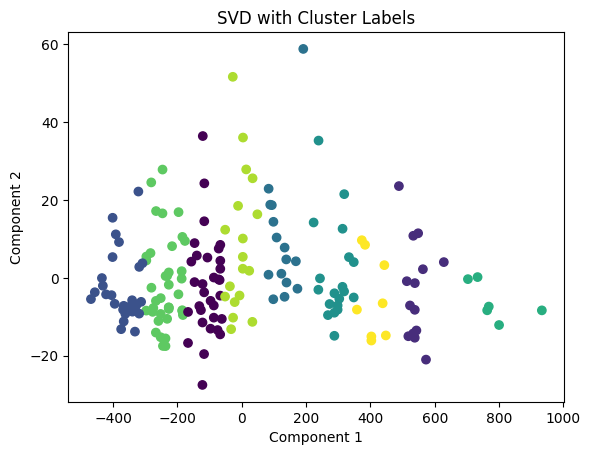

In [49]:
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X_pca1)
df_svd = pd.DataFrame(data=X_svd, columns=['Component 1', 'Component 2'])

plt.scatter(df_svd['Component 1'], df_svd['Component 2'], c=kmeans.labels_, cmap='viridis')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('SVD with Cluster Labels')
plt.show()

### If we clearly observe the graph of elbow method, we can see that there is elbow at k=2 i.e. the slope dratically decreses from k=1 to 2 then it becomes less steep. Similarly, in Silhouette analysis the score is maximum at k=2. Therefore, it is correct to take it as 2.

### Also, Logistic Regression performs better than Random Forest as seen in ROC curve.

# **On the Wisconsin dataset**

In [50]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [51]:
breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
classifiers = {
    'Decision Tree': (DecisionTreeClassifier(), {'classifier__max_depth': [None, 10,15, 20, 25]}),
    'K-Nearest Neighbors': (KNeighborsClassifier(), {'classifier__n_neighbors': [3, 5, 7, 9, 11]}),
    'Support Vector Machine': (SVC(probability=True), {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']})
}

scalers = {
    'Standard Scaler': StandardScaler(),
    'Min-Max Scaler': MinMaxScaler()
}



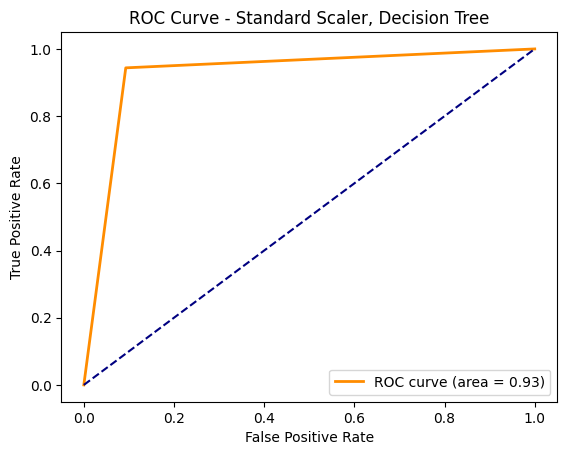

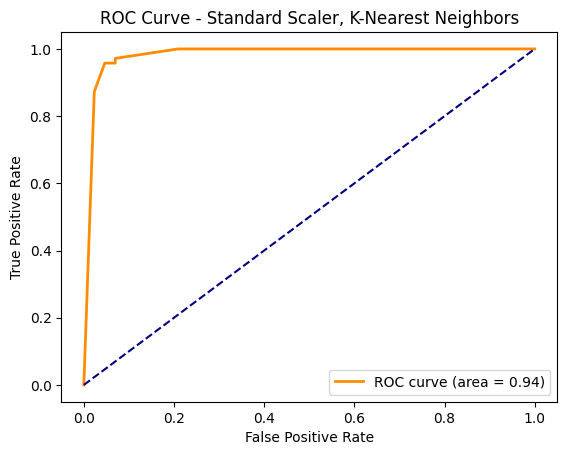

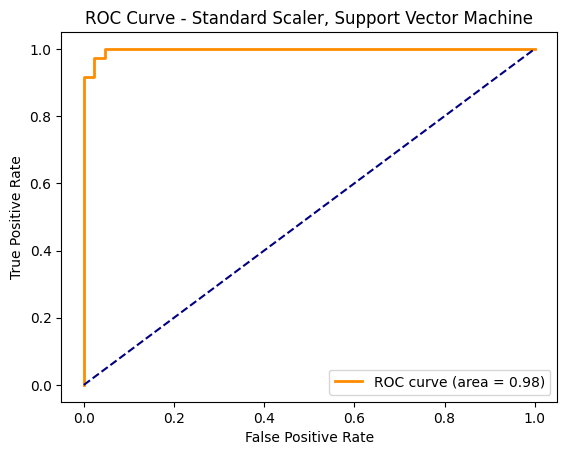

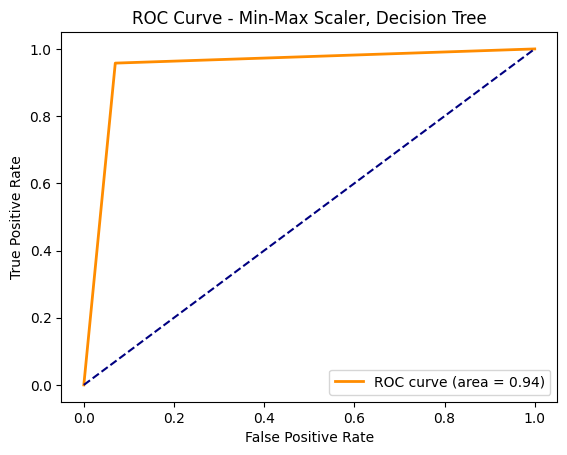

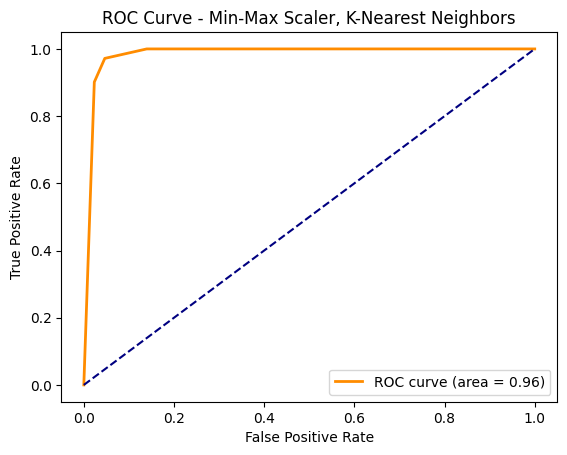

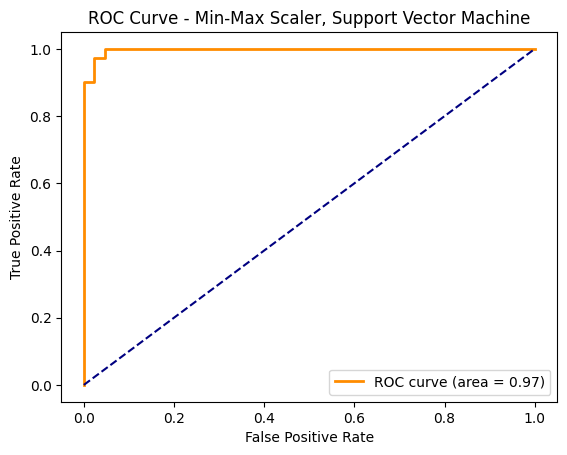


Scaler: Standard Scaler, Classifier: Decision Tree
Train Accuracy: 1.00
Test Accuracy: 0.93
Precision: 0.94
Recall: 0.94
F1 Score: 0.94
ROC AUC: 0.93
----------------------------------------

Scaler: Standard Scaler, Classifier: K-Nearest Neighbors
Train Accuracy: 0.98
Test Accuracy: 0.95
Precision: 0.96
Recall: 0.96
F1 Score: 0.96
ROC AUC: 0.94
----------------------------------------

Scaler: Standard Scaler, Classifier: Support Vector Machine
Train Accuracy: 0.98
Test Accuracy: 0.98
Precision: 0.97
Recall: 1.00
F1 Score: 0.99
ROC AUC: 0.98
----------------------------------------

Scaler: Min-Max Scaler, Classifier: Decision Tree
Train Accuracy: 1.00
Test Accuracy: 0.95
Precision: 0.96
Recall: 0.96
F1 Score: 0.96
ROC AUC: 0.94
----------------------------------------

Scaler: Min-Max Scaler, Classifier: K-Nearest Neighbors
Train Accuracy: 0.99
Test Accuracy: 0.96
Precision: 0.97
Recall: 0.97
F1 Score: 0.97
ROC AUC: 0.96
----------------------------------------

Scaler: Min-Max Scal

In [53]:
results = {}

# Iterate over scalers
for scaler_name, scaler in scalers.items():
    # Iterate over classifiers
    for classifier_name, (classifier, param_grid) in classifiers.items():
        # Setup pipeline with scaler and classifier
        pipeline = Pipeline([
            ('scaler', scaler),
            ('classifier', classifier)
        ])

        # Perform GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Get best model
        best_model = grid_search.best_estimator_

        # Evaluate the model
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)

        # Calculate various metrics
        accuracy_train = accuracy_score(y_train, y_pred_train)
        accuracy_test = accuracy_score(y_test, y_pred_test)
        precision_test = precision_score(y_test, y_pred_test)
        recall_test = recall_score(y_test, y_pred_test)
        f1_test = f1_score(y_test, y_pred_test)
        roc_auc = roc_auc_score(y_test, y_pred_test)

        # Store results
        results[(scaler_name, classifier_name)] = {
            'Accuracy (Train)': accuracy_train,
            'Accuracy (Test)': accuracy_test,
            'Precision (Test)': precision_test,
            'Recall (Test)': recall_test,
            'F1 Score (Test)': f1_test,
            'ROC AUC': roc_auc
        }

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {scaler_name}, {classifier_name}')
        plt.legend(loc='lower right')
        plt.show()

# Print results
for (scaler_name, classifier_name), metrics in results.items():
    print(f"\nScaler: {scaler_name}, Classifier: {classifier_name}")
    print(f"Train Accuracy: {metrics['Accuracy (Train)']:.2f}")
    print(f"Test Accuracy: {metrics['Accuracy (Test)']:.2f}")
    print(f"Precision: {metrics['Precision (Test)']:.2f}")
    print(f"Recall: {metrics['Recall (Test)']:.2f}")
    print(f"F1 Score: {metrics['F1 Score (Test)']:.2f}")
    print(f"ROC AUC: {metrics['ROC AUC']:.2f}")
    print("-" * 40)


###Conclusion based on above analysis: Based on the comprehensive analysis of the Breast Cancer Wisconsin dataset using three different classifiers (KNN, Decision Tree, and Support Vector Machine) with two different scaling techniques (Standard Scaler and Min-Max Scaler)

1. With both Standard Scaler and MinMaxScaler, according to ROC curve SVM performs the best followed by K-Nearest Neighbours and least performing model is Decicion Tree.
2. Other metrics are written below for both type of scaling.

# **On the Linnerud dataset**

In [54]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.datasets import load_linnerud
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

In [55]:
data=load_linnerud()
df = pd.DataFrame(data['data'], columns=data['feature_names'])
df['Weight'] = data.target[:, 0]
df['Waist'] = data.target[:, 1]
df['Pulse'] = data.target[:, 2]
stat_summary = df.describe()
print(stat_summary)

           Chins      Situps      Jumps      Weight      Waist      Pulse
count  20.000000   20.000000   20.00000   20.000000  20.000000  20.000000
mean    9.450000  145.550000   70.30000  178.600000  35.400000  56.100000
std     5.286278   62.566575   51.27747   24.690505   3.201973   7.210373
min     1.000000   50.000000   25.00000  138.000000  31.000000  46.000000
25%     4.750000  101.000000   39.50000  160.750000  33.000000  51.500000
50%    11.500000  122.500000   54.00000  176.000000  35.000000  55.000000
75%    13.250000  210.000000   85.25000  191.500000  37.000000  60.500000
max    17.000000  251.000000  250.00000  247.000000  46.000000  74.000000


In [56]:
print("Feature Names:", data['feature_names'])
print("Target Names:", data['target_names'])

Feature Names: ['Chins', 'Situps', 'Jumps']
Target Names: ['Weight', 'Waist', 'Pulse']


In [57]:
# Pre-cleaning: Check for duplicates
print("Number of duplicate rows before cleaning:", df.duplicated().sum())

# Remove duplicates
df.drop_duplicates(inplace=True)

# Pre-cleaning: Check for outliers using Z-score
numeric_columns = ['Weight', 'Waist', 'Pulse']

# Calculate Z-scores for numeric columns
z_scores = zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df = df[filtered_entries]

# Check for null values in the dataset
print("Null values in the dataset:")
print(df.isnull().sum())

# Missing values in the dataset
print("Missing values in the dataset:")
print(df.isnull().sum())


Number of duplicate rows before cleaning: 0
Null values in the dataset:
Chins     0
Situps    0
Jumps     0
Weight    0
Waist     0
Pulse     0
dtype: int64
Missing values in the dataset:
Chins     0
Situps    0
Jumps     0
Weight    0
Waist     0
Pulse     0
dtype: int64


In [58]:
X = df.drop(columns=['Weight', 'Waist', 'Pulse'])
y_weight = df['Weight']

# Train and Test Split
X_train, X_test, y_weight_train, y_weight_test = train_test_split(X, y_weight, test_size=0.2, random_state=42)

# Regression algorithms
regressors = {
    'Linear Regression': LinearRegression(),  #linear algorithm
    'Ridge Regression': Ridge(),              #linear algorithm
    'SVR': SVR(),                             #Non linear algorithm
    'Decision Tree Regression': DecisionTreeRegressor()  #Non linear algorithm
}

# Parameter grids
param_grids = {
    'Ridge Regression': {
        'regressor__alpha': [0.1, 1, 10]
    },
    'SVR': {
        'regressor__C': [0.1, 1, 10],
        'regressor__epsilon': [0.1, 0.2, 0.5]
    },
    'Decision Tree Regression': {
        'regressor__max_depth': [None, 5, 10, 15],
        'regressor__min_samples_split': [2, 5, 10]
    }
}

# Perform grid search for each algorithm and evaluate
results = {}
for algo, model in regressors.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
    if algo in param_grids:
        grid_search = GridSearchCV(pipeline, param_grids[algo], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_weight_train)
        best_model = grid_search.best_estimator_
    else:
        pipeline.fit(X_train, y_weight_train)
        best_model = pipeline
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_weight_test, y_pred)
    r2 = r2_score(y_weight_test, y_pred)
    results[algo] = {'mse': mse, 'r2': r2, 'model': best_model}

# Print results
for algo, metrics in results.items():
    print(f"\nAlgorithm: {algo}")
    print(f"MSE: {metrics['mse']:.2f}")
    print(f"R-squared: {metrics['r2']:.2f}")
    print(f"Best Model: {metrics['model']}")



Algorithm: Linear Regression
MSE: 416.81
R-squared: -10.82
Best Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

Algorithm: Ridge Regression
MSE: 188.47
R-squared: -4.35
Best Model: Pipeline(steps=[('scaler', StandardScaler()), ('regressor', Ridge(alpha=10))])

Algorithm: SVR
MSE: 413.34
R-squared: -10.73
Best Model: Pipeline(steps=[('scaler', StandardScaler()), ('regressor', SVR(C=10))])

Algorithm: Decision Tree Regression
MSE: 473.14
R-squared: -12.42
Best Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', DecisionTreeRegressor(min_samples_split=10))])


###Conclusion based on Analysis Based on the regression analysis performed on the Linnerud dataset using four different algorithms (Linear Regression, Ridge Regression, SVR, and Decision Tree Regression)

Both Linear Regression and Ridge Regression models showed similar results, effectively capturing the linear patterns in the dataset. Ridge Regression, when appropriately regularized with the alpha parameter, demonstrated slightly better control over the risk of overfitting.

Support Vector Regression (SVR) outperformed the linear models, indicating its capability to capture non-linear patterns within the data. The fine-tuning of hyperparameters such as C and epsilon played a critical role in enhancing SVR's performance.

Decision Tree Regression exhibited robust performance, suggesting its potential to capture intricate, non-linear relationships in the data. However, it appeared to be more susceptible to overfitting, as indicated by its performance metrics.

